In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
data_path = "./data/"
file_name_list = os.listdir(data_path)
csv_name_list = [file for file in file_name_list if file.endswith(".csv")]
print(len(csv_name_list))
print(csv_name_list)
cal = pd.read_csv(data_path+csv_name_list[0])
price = pd.read_csv(data_path+csv_name_list[1])
main = pd.read_csv(data_path+csv_name_list[2])
print(cal.shape)
print(price.shape)
print(main.shape)
print(main.cat_id.unique())

4
['calendar.csv', 'sell_prices.csv', 'sales_train_validation.csv', 'sample_submission.csv']
(1969, 14)
(6841121, 4)
(30490, 1919)
['HOBBIES' 'HOUSEHOLD' 'FOODS']


In [3]:
def return_data_set_by_cat1(main, price, cal, cat):
    cat_df = main[main.cat_id==cat]
    print(cat_df.shape)
    print("Num / Total  =  {}".format(float(len(cat_df))/float(len(main))))
    
    cat_sales_count_sum = cat_df[cat_df.columns[6:]].sum(axis=0)
    
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(cat_sales_count_sum)
    plt.show()
    
    def return_cat1(raw):
        return raw.split("_")[0]

    price["cat1"] = price["item_id"].apply(return_cat1)
    cat_price = price[price.cat1==cat][["wm_yr_wk","sell_price"]]
    cat_price_sum = cat_price.groupby(["wm_yr_wk"]).sum()
    
    merge_df = pd.merge(cal, cat_price_sum, how='left', left_on="wm_yr_wk", right_index=True)
    
    cat_sales_count_sum_df = pd.DataFrame(cat_sales_count_sum, columns=["sum_of_counts"])
    merge_df = pd.merge(cat_sales_count_sum_df, merge_df, how='left', left_index=True, right_on='d')
    
    need_df = merge_df[["sum_of_counts","wday","month","year","event_name_1","event_type_1","event_name_2","event_type_2","snap_CA","snap_TX","snap_WI","sell_price"]]
    need_df.fillna("none", inplace=True)
    cat_col = ['wday', 'month', 'year', 'event_name_1','event_type_1', 'event_name_2', 'event_type_2']
    for col in cat_col:
        need_df[col] = need_df[col].astype('category')
        
    input_df = need_df[need_df.columns[1:]]
    target_df = need_df[need_df.columns[:1]]

    x_train = input_df.iloc[:-365]
    y_train = target_df.iloc[:-365]
    x_test = input_df.iloc[-365:]
    y_test = target_df.iloc[-365:]

    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return x_train, y_train, x_test, y_test

# Hobbies

(5650, 1919)
Num / Total  =  0.18530665792062972


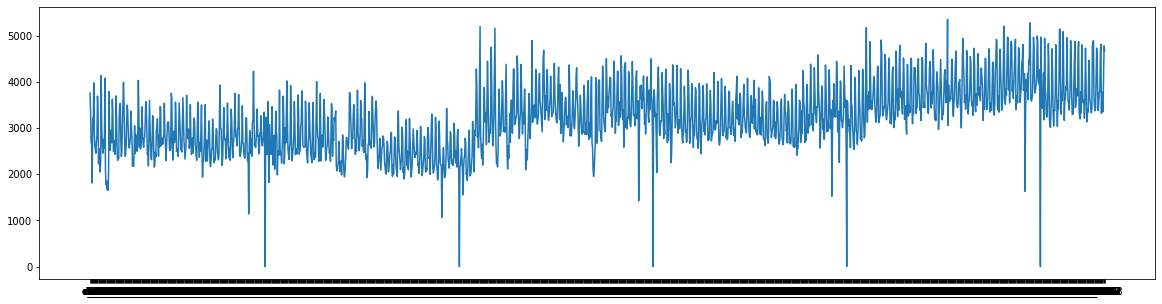

(1548, 11) (1548, 1) (365, 11) (365, 1)


/Users/jaemin/opt/anaconda3/envs/py36t2/lib/python3.6/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs
/Users/jaemin/opt/anaconda3/envs/py36t2/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
hobby_x_train, hobby_y_train, hobby_x_test, hobby_y_test = return_data_set_by_cat1(main=main, price=price, cal=cal, cat="HOBBIES")

In [6]:
lgb_train = lgb.Dataset(hobby_x_train, hobby_y_train)
lgb_eval = lgb.Dataset(hobby_x_test, hobby_y_test)
params = {
    'boosting_type': 'gbdt',
    'max_depth' : 10,
    'objective': 'regression',
    #'num_leaves': 10,
    'learning_rate': 0.005,
    'metric' : ['l2'],
    #multi_logloss
    #multi_error
    'random_state': 501,
    'categorical_feature':['wday', 'month', 'year', 'event_name_1','event_type_1', 'event_name_2', 'event_type_2'],
    
}

print('Starting training...')
#mdl.fit(X=train_tot,y=y_train, eval_set=(valid_tot, y_val), eval_metric=['multi_error','multi_logloss'])
gbm = lgb.train(params,lgb_train,num_boost_round=30000,valid_sets=lgb_eval,early_stopping_rounds=500)

Starting training...
[1]	valid_0's l2: 1.05949e+06
Training until validation scores don't improve for 500 rounds
[2]	valid_0's l2: 1.05228e+06
[3]	valid_0's l2: 1.04514e+06
[4]	valid_0's l2: 1.03806e+06
[5]	valid_0's l2: 1.03105e+06
[6]	valid_0's l2: 1.02411e+06
[7]	valid_0's l2: 1.01722e+06
[8]	valid_0's l2: 1.0104e+06
[9]	valid_0's l2: 1.00365e+06
[10]	valid_0's l2: 996950
[11]	valid_0's l2: 990315
[12]	valid_0's l2: 983494
[13]	valid_0's l2: 976735
[14]	valid_0's l2: 970037
[15]	valid_0's l2: 963401
[16]	valid_0's l2: 957059
[17]	valid_0's l2: 950539
[18]	valid_0's l2: 944079
[19]	valid_0's l2: 938172
[20]	valid_0's l2: 931823
[21]	valid_0's l2: 926020
[22]	valid_0's l2: 919779
[23]	valid_0's l2: 914078
[24]	valid_0's l2: 907944
[25]	valid_0's l2: 902342
[26]	valid_0's l2: 896789
[27]	valid_0's l2: 890810
[28]	valid_0's l2: 885354
[29]	valid_0's l2: 879477
[30]	valid_0's l2: 874116
[31]	valid_0's l2: 868802
[32]	valid_0's l2: 863072
[33]	valid_0's l2: 857851
[34]	valid_0's l2: 85221

/Users/jaemin/opt/anaconda3/envs/py36t2/lib/python3.6/site-packages/lightgbm/basic.py:842: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/Users/jaemin/opt/anaconda3/envs/py36t2/lib/python3.6/site-packages/lightgbm/basic.py:863: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[232]	valid_0's l2: 348134
[233]	valid_0's l2: 347196
[234]	valid_0's l2: 346158
[235]	valid_0's l2: 345174
[236]	valid_0's l2: 344120
[237]	valid_0's l2: 343187
[238]	valid_0's l2: 342250
[239]	valid_0's l2: 341204
[240]	valid_0's l2: 340308
[241]	valid_0's l2: 339425
[242]	valid_0's l2: 338464
[243]	valid_0's l2: 337537
[244]	valid_0's l2: 336674
[245]	valid_0's l2: 335781
[246]	valid_0's l2: 334909
[247]	valid_0's l2: 334018
[248]	valid_0's l2: 333048
[249]	valid_0's l2: 332197
[250]	valid_0's l2: 331259
[251]	valid_0's l2: 330414
[252]	valid_0's l2: 329547
[253]	valid_0's l2: 328579
[254]	valid_0's l2: 327777
[255]	valid_0's l2: 326979
[256]	valid_0's l2: 326063
[257]	valid_0's l2: 325255
[258]	valid_0's l2: 324454
[259]	valid_0's l2: 323569
[260]	valid_0's l2: 322823
[261]	valid_0's l2: 321852
[262]	valid_0's l2: 321051
[263]	valid_0's l2: 320194
[264]	valid_0's l2: 319449
[265]	valid_0's l2: 318561
[266]	valid_0's l2: 317735
[267]	valid_0's l2: 316963
[268]	valid_0's l2: 316136
[

[667]	valid_0's l2: 200570
[668]	valid_0's l2: 200481
[669]	valid_0's l2: 200427
[670]	valid_0's l2: 200341
[671]	valid_0's l2: 200252
[672]	valid_0's l2: 200167
[673]	valid_0's l2: 200079
[674]	valid_0's l2: 199992
[675]	valid_0's l2: 199908
[676]	valid_0's l2: 199816
[677]	valid_0's l2: 199730
[678]	valid_0's l2: 199647
[679]	valid_0's l2: 199554
[680]	valid_0's l2: 199452
[681]	valid_0's l2: 199407
[682]	valid_0's l2: 199357
[683]	valid_0's l2: 199266
[684]	valid_0's l2: 199180
[685]	valid_0's l2: 199132
[686]	valid_0's l2: 199038
[687]	valid_0's l2: 198995
[688]	valid_0's l2: 198910
[689]	valid_0's l2: 198828
[690]	valid_0's l2: 198746
[691]	valid_0's l2: 198675
[692]	valid_0's l2: 198586
[693]	valid_0's l2: 198546
[694]	valid_0's l2: 198455
[695]	valid_0's l2: 198411
[696]	valid_0's l2: 198331
[697]	valid_0's l2: 198258
[698]	valid_0's l2: 198215
[699]	valid_0's l2: 198203
[700]	valid_0's l2: 198127
[701]	valid_0's l2: 198027
[702]	valid_0's l2: 197950
[703]	valid_0's l2: 197871
[

[1108]	valid_0's l2: 186980
[1109]	valid_0's l2: 187021
[1110]	valid_0's l2: 186960
[1111]	valid_0's l2: 186938
[1112]	valid_0's l2: 186865
[1113]	valid_0's l2: 186979
[1114]	valid_0's l2: 186919
[1115]	valid_0's l2: 186859
[1116]	valid_0's l2: 186869
[1117]	valid_0's l2: 186853
[1118]	valid_0's l2: 186950
[1119]	valid_0's l2: 186947
[1120]	valid_0's l2: 186925
[1121]	valid_0's l2: 186922
[1122]	valid_0's l2: 186929
[1123]	valid_0's l2: 186923
[1124]	valid_0's l2: 186950
[1125]	valid_0's l2: 186886
[1126]	valid_0's l2: 186976
[1127]	valid_0's l2: 186971
[1128]	valid_0's l2: 187003
[1129]	valid_0's l2: 186995
[1130]	valid_0's l2: 186974
[1131]	valid_0's l2: 186911
[1132]	valid_0's l2: 186943
[1133]	valid_0's l2: 186893
[1134]	valid_0's l2: 186993
[1135]	valid_0's l2: 186930
[1136]	valid_0's l2: 186873
[1137]	valid_0's l2: 186903
[1138]	valid_0's l2: 186854
[1139]	valid_0's l2: 186958
[1140]	valid_0's l2: 186909
[1141]	valid_0's l2: 186941
[1142]	valid_0's l2: 186906
[1143]	valid_0's l2:

[1461]	valid_0's l2: 183527
[1462]	valid_0's l2: 183538
[1463]	valid_0's l2: 183520
[1464]	valid_0's l2: 183553
[1465]	valid_0's l2: 183541
[1466]	valid_0's l2: 183554
[1467]	valid_0's l2: 183523
[1468]	valid_0's l2: 183556
[1469]	valid_0's l2: 183526
[1470]	valid_0's l2: 183539
[1471]	valid_0's l2: 183519
[1472]	valid_0's l2: 183528
[1473]	valid_0's l2: 183518
[1474]	valid_0's l2: 183528
[1475]	valid_0's l2: 183491
[1476]	valid_0's l2: 183523
[1477]	valid_0's l2: 183513
[1478]	valid_0's l2: 183541
[1479]	valid_0's l2: 183509
[1480]	valid_0's l2: 183541
[1481]	valid_0's l2: 183530
[1482]	valid_0's l2: 183529
[1483]	valid_0's l2: 183549
[1484]	valid_0's l2: 183561
[1485]	valid_0's l2: 183551
[1486]	valid_0's l2: 183583
[1487]	valid_0's l2: 183553
[1488]	valid_0's l2: 183566
[1489]	valid_0's l2: 183524
[1490]	valid_0's l2: 183556
[1491]	valid_0's l2: 183582
[1492]	valid_0's l2: 183564
[1493]	valid_0's l2: 183554
[1494]	valid_0's l2: 183553
[1495]	valid_0's l2: 183572
[1496]	valid_0's l2:

[1882]	valid_0's l2: 181165
[1883]	valid_0's l2: 181152
[1884]	valid_0's l2: 181154
[1885]	valid_0's l2: 181146
[1886]	valid_0's l2: 181166
[1887]	valid_0's l2: 181153
[1888]	valid_0's l2: 181170
[1889]	valid_0's l2: 181183
[1890]	valid_0's l2: 181176
[1891]	valid_0's l2: 181198
[1892]	valid_0's l2: 181183
[1893]	valid_0's l2: 181206
[1894]	valid_0's l2: 181194
[1895]	valid_0's l2: 181217
[1896]	valid_0's l2: 181210
[1897]	valid_0's l2: 181226
[1898]	valid_0's l2: 181239
[1899]	valid_0's l2: 181232
[1900]	valid_0's l2: 181246
[1901]	valid_0's l2: 181235
[1902]	valid_0's l2: 181251
[1903]	valid_0's l2: 181245
[1904]	valid_0's l2: 181258
[1905]	valid_0's l2: 181273
[1906]	valid_0's l2: 181262
[1907]	valid_0's l2: 181269
[1908]	valid_0's l2: 181257
[1909]	valid_0's l2: 181274
[1910]	valid_0's l2: 181268
[1911]	valid_0's l2: 181298
[1912]	valid_0's l2: 181299
[1913]	valid_0's l2: 181293
[1914]	valid_0's l2: 181327
[1915]	valid_0's l2: 181316
[1916]	valid_0's l2: 181328
[1917]	valid_0's l2:

[2373]	valid_0's l2: 180434
[2374]	valid_0's l2: 180440
[2375]	valid_0's l2: 180392
[2376]	valid_0's l2: 180422
[2377]	valid_0's l2: 180370
[2378]	valid_0's l2: 180375
[2379]	valid_0's l2: 180364
[2380]	valid_0's l2: 180313
[2381]	valid_0's l2: 180336
[2382]	valid_0's l2: 180289
[2383]	valid_0's l2: 180294
[2384]	valid_0's l2: 180290
[2385]	valid_0's l2: 180322
[2386]	valid_0's l2: 180276
[2387]	valid_0's l2: 180298
[2388]	valid_0's l2: 180305
[2389]	valid_0's l2: 180294
[2390]	valid_0's l2: 180289
[2391]	valid_0's l2: 180279
[2392]	valid_0's l2: 180297
[2393]	valid_0's l2: 180282
[2394]	valid_0's l2: 180272
[2395]	valid_0's l2: 180266
[2396]	valid_0's l2: 180296
[2397]	valid_0's l2: 180281
[2398]	valid_0's l2: 180271
[2399]	valid_0's l2: 180265
[2400]	valid_0's l2: 180281
[2401]	valid_0's l2: 180270
[2402]	valid_0's l2: 180283
[2403]	valid_0's l2: 180273
[2404]	valid_0's l2: 180306
[2405]	valid_0's l2: 180259
[2406]	valid_0's l2: 180272
[2407]	valid_0's l2: 180262
[2408]	valid_0's l2:

[2790]	valid_0's l2: 178764
[2791]	valid_0's l2: 178768
[2792]	valid_0's l2: 178767
[2793]	valid_0's l2: 178772
[2794]	valid_0's l2: 178769
[2795]	valid_0's l2: 178765
[2796]	valid_0's l2: 178770
[2797]	valid_0's l2: 178768
[2798]	valid_0's l2: 178755
[2799]	valid_0's l2: 178754
[2800]	valid_0's l2: 178756
[2801]	valid_0's l2: 178761
[2802]	valid_0's l2: 178760
[2803]	valid_0's l2: 178805
[2804]	valid_0's l2: 178810
[2805]	valid_0's l2: 178811
[2806]	valid_0's l2: 178821
[2807]	valid_0's l2: 178816
[2808]	valid_0's l2: 178860
[2809]	valid_0's l2: 178863
[2810]	valid_0's l2: 178871
[2811]	valid_0's l2: 178916
[2812]	valid_0's l2: 178919
[2813]	valid_0's l2: 178920
[2814]	valid_0's l2: 178928
[2815]	valid_0's l2: 178923
[2816]	valid_0's l2: 178938
[2817]	valid_0's l2: 178944
[2818]	valid_0's l2: 178940
[2819]	valid_0's l2: 178941
[2820]	valid_0's l2: 178942
[2821]	valid_0's l2: 178941
[2822]	valid_0's l2: 178985
[2823]	valid_0's l2: 178976
[2824]	valid_0's l2: 178962
[2825]	valid_0's l2:

[3232]	valid_0's l2: 179880
[3233]	valid_0's l2: 179864
[3234]	valid_0's l2: 179888
[3235]	valid_0's l2: 179907
[3236]	valid_0's l2: 179914
[3237]	valid_0's l2: 179932
[3238]	valid_0's l2: 179922
[3239]	valid_0's l2: 179941
[3240]	valid_0's l2: 179924
[3241]	valid_0's l2: 179914
[3242]	valid_0's l2: 179897
[3243]	valid_0's l2: 179889
[3244]	valid_0's l2: 179867
[3245]	valid_0's l2: 179851
[3246]	valid_0's l2: 179856
[3247]	valid_0's l2: 179875
[3248]	valid_0's l2: 179870
[3249]	valid_0's l2: 179898
[3250]	valid_0's l2: 179926
[3251]	valid_0's l2: 179946
[3252]	valid_0's l2: 179954
[3253]	valid_0's l2: 179963
[3254]	valid_0's l2: 179991
[3255]	valid_0's l2: 180013
[3256]	valid_0's l2: 180033
[3257]	valid_0's l2: 180061
[3258]	valid_0's l2: 180081
[3259]	valid_0's l2: 180088
[3260]	valid_0's l2: 180093
[3261]	valid_0's l2: 180121
[3262]	valid_0's l2: 180127
[3263]	valid_0's l2: 180133
[3264]	valid_0's l2: 180108
[3265]	valid_0's l2: 180106
[3266]	valid_0's l2: 180090
[3267]	valid_0's l2:

In [8]:
train_pred = gbm.predict(hobby_x_train, num_iteration=gbm.best_iteration)
test_pred = gbm.predict(hobby_x_test, num_iteration=gbm.best_iteration)

print("In train set")
print("MSE = {}  MAE = {}".format(mean_squared_error(hobby_y_train, train_pred), mean_absolute_error(hobby_y_train, train_pred)))
print("In test set")
print("MSE = {}  MAE = {}".format(mean_squared_error(hobby_y_test, test_pred), mean_absolute_error(hobby_y_test, test_pred)))

In train set
MSE = 46279.838165806206  MAE = 153.8835258756913
In test set
MSE = 177880.30868379283  MAE = 320.505997477626


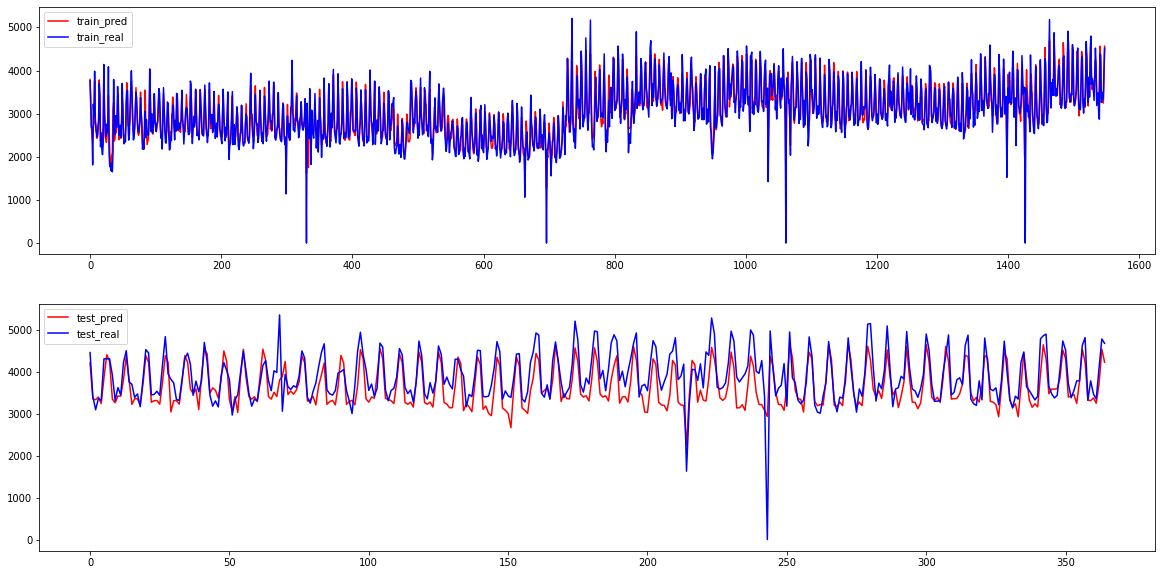

In [9]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.plot(train_pred, color='r', label='train_pred')
ax1.plot(hobby_y_train.values, color='b', label='train_real')
ax2.plot(test_pred, color='r', label='test_pred')
ax2.plot(hobby_y_test.values, color='b', label='test_real')
ax1.legend()
ax2.legend()
plt.show()

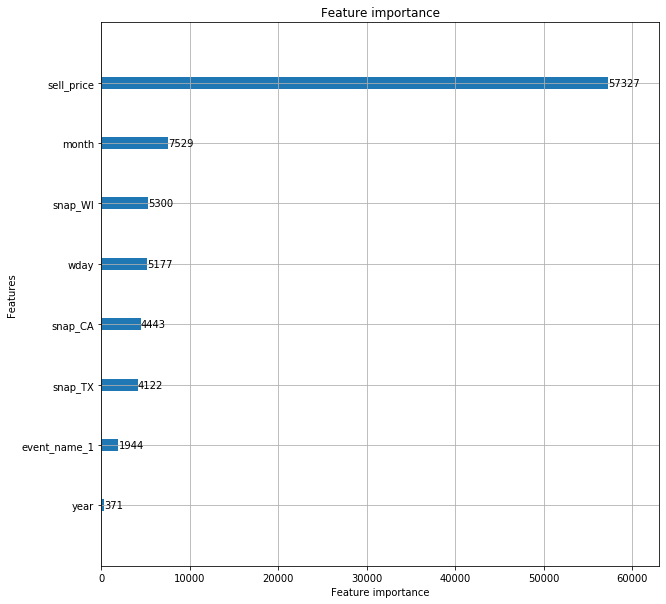

In [10]:
lgb.plot_importance(gbm, max_num_features=50, importance_type='split', figsize=(10,10))

# Household

(10470, 1919)
Num / Total  =  0.3433912758281404


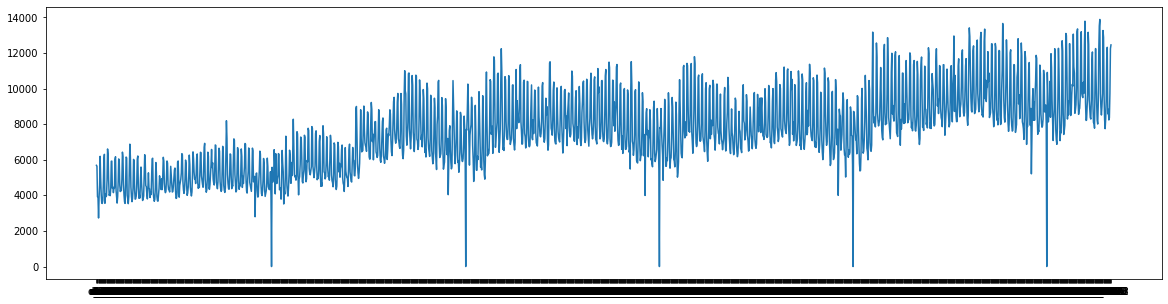

(1548, 11) (1548, 1) (365, 11) (365, 1)


/Users/jaemin/opt/anaconda3/envs/py36t2/lib/python3.6/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs
/Users/jaemin/opt/anaconda3/envs/py36t2/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
house_x_train, house_y_train, house_x_test, house_y_test = return_data_set_by_cat1(main=main, price=price, cal=cal, cat="HOUSEHOLD")

In [12]:
lgb_train = lgb.Dataset(house_x_train, house_y_train)
lgb_eval = lgb.Dataset(house_x_test, house_y_test)
params = {
    'boosting_type': 'gbdt',
    'max_depth' : 10,
    'objective': 'regression',
    #'num_leaves': 10,
    'learning_rate': 0.005,
    'metric' : ['l2'],
    #multi_logloss
    #multi_error
    'random_state': 501,
    'categorical_feature':['wday', 'month', 'year', 'event_name_1','event_type_1', 'event_name_2', 'event_type_2'],
    
}

print('Starting training...')
#mdl.fit(X=train_tot,y=y_train, eval_set=(valid_tot, y_val), eval_metric=['multi_error','multi_logloss'])
gbm = lgb.train(params,lgb_train,num_boost_round=30000,valid_sets=lgb_eval,early_stopping_rounds=500)

Starting training...
[1]	valid_0's l2: 9.67471e+06
Training until validation scores don't improve for 500 rounds
[2]	valid_0's l2: 9.60272e+06
[3]	valid_0's l2: 9.53142e+06
[4]	valid_0's l2: 9.4608e+06
[5]	valid_0's l2: 9.39085e+06
[6]	valid_0's l2: 9.32156e+06
[7]	valid_0's l2: 9.25294e+06
[8]	valid_0's l2: 9.18497e+06
[9]	valid_0's l2: 9.11747e+06
[10]	valid_0's l2: 9.05079e+06
[11]	valid_0's l2: 8.98457e+06
[12]	valid_0's l2: 8.91914e+06
[13]	valid_0's l2: 8.85417e+06
[14]	valid_0's l2: 8.78998e+06
[15]	valid_0's l2: 8.72627e+06
[16]	valid_0's l2: 8.66315e+06
[17]	valid_0's l2: 8.60064e+06
[18]	valid_0's l2: 8.53864e+06
[19]	valid_0's l2: 8.47691e+06
[20]	valid_0's l2: 8.41616e+06
[21]	valid_0's l2: 8.35576e+06
[22]	valid_0's l2: 8.29598e+06
[23]	valid_0's l2: 8.23672e+06
[24]	valid_0's l2: 8.17806e+06
[25]	valid_0's l2: 8.11973e+06
[26]	valid_0's l2: 8.06235e+06
[27]	valid_0's l2: 8.0053e+06
[28]	valid_0's l2: 7.94882e+06
[29]	valid_0's l2: 7.89285e+06
[30]	valid_0's l2: 7.83742e+0

/Users/jaemin/opt/anaconda3/envs/py36t2/lib/python3.6/site-packages/lightgbm/basic.py:842: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/Users/jaemin/opt/anaconda3/envs/py36t2/lib/python3.6/site-packages/lightgbm/basic.py:863: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[219]	valid_0's l2: 2.98292e+06
[220]	valid_0's l2: 2.97443e+06
[221]	valid_0's l2: 2.96485e+06
[222]	valid_0's l2: 2.95609e+06
[223]	valid_0's l2: 2.94667e+06
[224]	valid_0's l2: 2.9381e+06
[225]	valid_0's l2: 2.92882e+06
[226]	valid_0's l2: 2.92072e+06
[227]	valid_0's l2: 2.9121e+06
[228]	valid_0's l2: 2.90303e+06
[229]	valid_0's l2: 2.89512e+06
[230]	valid_0's l2: 2.88669e+06
[231]	valid_0's l2: 2.87737e+06
[232]	valid_0's l2: 2.86966e+06
[233]	valid_0's l2: 2.86081e+06
[234]	valid_0's l2: 2.85259e+06
[235]	valid_0's l2: 2.84505e+06
[236]	valid_0's l2: 2.83585e+06
[237]	valid_0's l2: 2.82782e+06
[238]	valid_0's l2: 2.81876e+06
[239]	valid_0's l2: 2.81105e+06
[240]	valid_0's l2: 2.80347e+06
[241]	valid_0's l2: 2.79461e+06
[242]	valid_0's l2: 2.78687e+06
[243]	valid_0's l2: 2.77827e+06
[244]	valid_0's l2: 2.7712e+06
[245]	valid_0's l2: 2.76363e+06
[246]	valid_0's l2: 2.75509e+06
[247]	valid_0's l2: 2.74803e+06
[248]	valid_0's l2: 2.73962e+06
[249]	valid_0's l2: 2.73227e+06
[250]	valid

[685]	valid_0's l2: 1.5611e+06
[686]	valid_0's l2: 1.56064e+06
[687]	valid_0's l2: 1.55906e+06
[688]	valid_0's l2: 1.55867e+06
[689]	valid_0's l2: 1.55823e+06
[690]	valid_0's l2: 1.55697e+06
[691]	valid_0's l2: 1.55653e+06
[692]	valid_0's l2: 1.55527e+06
[693]	valid_0's l2: 1.5549e+06
[694]	valid_0's l2: 1.55386e+06
[695]	valid_0's l2: 1.55349e+06
[696]	valid_0's l2: 1.55265e+06
[697]	valid_0's l2: 1.55222e+06
[698]	valid_0's l2: 1.55108e+06
[699]	valid_0's l2: 1.55066e+06
[700]	valid_0's l2: 1.55044e+06
[701]	valid_0's l2: 1.5493e+06
[702]	valid_0's l2: 1.54895e+06
[703]	valid_0's l2: 1.54789e+06
[704]	valid_0's l2: 1.54755e+06
[705]	valid_0's l2: 1.54663e+06
[706]	valid_0's l2: 1.54623e+06
[707]	valid_0's l2: 1.54533e+06
[708]	valid_0's l2: 1.545e+06
[709]	valid_0's l2: 1.54411e+06
[710]	valid_0's l2: 1.54372e+06
[711]	valid_0's l2: 1.54265e+06
[712]	valid_0's l2: 1.54233e+06
[713]	valid_0's l2: 1.54213e+06
[714]	valid_0's l2: 1.54182e+06
[715]	valid_0's l2: 1.54094e+06
[716]	valid_0

[1088]	valid_0's l2: 1.38383e+06
[1089]	valid_0's l2: 1.38378e+06
[1090]	valid_0's l2: 1.38376e+06
[1091]	valid_0's l2: 1.3836e+06
[1092]	valid_0's l2: 1.3835e+06
[1093]	valid_0's l2: 1.38346e+06
[1094]	valid_0's l2: 1.3833e+06
[1095]	valid_0's l2: 1.38328e+06
[1096]	valid_0's l2: 1.3833e+06
[1097]	valid_0's l2: 1.38317e+06
[1098]	valid_0's l2: 1.38315e+06
[1099]	valid_0's l2: 1.38299e+06
[1100]	valid_0's l2: 1.38295e+06
[1101]	valid_0's l2: 1.38301e+06
[1102]	valid_0's l2: 1.38288e+06
[1103]	valid_0's l2: 1.38276e+06
[1104]	valid_0's l2: 1.38261e+06
[1105]	valid_0's l2: 1.38241e+06
[1106]	valid_0's l2: 1.3823e+06
[1107]	valid_0's l2: 1.38217e+06
[1108]	valid_0's l2: 1.38217e+06
[1109]	valid_0's l2: 1.38203e+06
[1110]	valid_0's l2: 1.3819e+06
[1111]	valid_0's l2: 1.38159e+06
[1112]	valid_0's l2: 1.38145e+06
[1113]	valid_0's l2: 1.38138e+06
[1114]	valid_0's l2: 1.38124e+06
[1115]	valid_0's l2: 1.38107e+06
[1116]	valid_0's l2: 1.38077e+06
[1117]	valid_0's l2: 1.38064e+06
[1118]	valid_0's

[1486]	valid_0's l2: 1.33149e+06
[1487]	valid_0's l2: 1.33118e+06
[1488]	valid_0's l2: 1.33094e+06
[1489]	valid_0's l2: 1.33148e+06
[1490]	valid_0's l2: 1.33151e+06
[1491]	valid_0's l2: 1.33155e+06
[1492]	valid_0's l2: 1.33208e+06
[1493]	valid_0's l2: 1.33212e+06
[1494]	valid_0's l2: 1.33173e+06
[1495]	valid_0's l2: 1.33177e+06
[1496]	valid_0's l2: 1.3314e+06
[1497]	valid_0's l2: 1.33193e+06
[1498]	valid_0's l2: 1.33196e+06
[1499]	valid_0's l2: 1.33172e+06
[1500]	valid_0's l2: 1.33135e+06
[1501]	valid_0's l2: 1.33188e+06
[1502]	valid_0's l2: 1.33191e+06
[1503]	valid_0's l2: 1.33236e+06
[1504]	valid_0's l2: 1.33239e+06
[1505]	valid_0's l2: 1.33242e+06
[1506]	valid_0's l2: 1.33274e+06
[1507]	valid_0's l2: 1.33276e+06
[1508]	valid_0's l2: 1.3324e+06
[1509]	valid_0's l2: 1.33292e+06
[1510]	valid_0's l2: 1.33295e+06
[1511]	valid_0's l2: 1.33347e+06
[1512]	valid_0's l2: 1.33349e+06
[1513]	valid_0's l2: 1.33325e+06
[1514]	valid_0's l2: 1.33327e+06
[1515]	valid_0's l2: 1.33372e+06
[1516]	valid

In train set
MSE = 250020.44895845733  MAE = 335.43642691063445
In test set
MSE = 1328426.352121563  MAE = 883.6810572511741


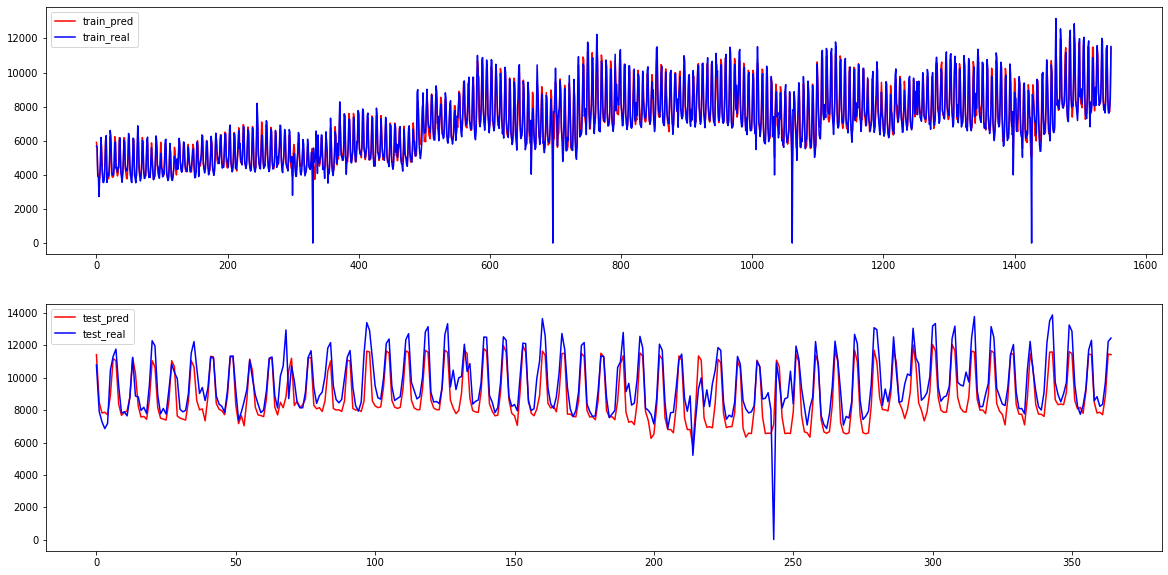

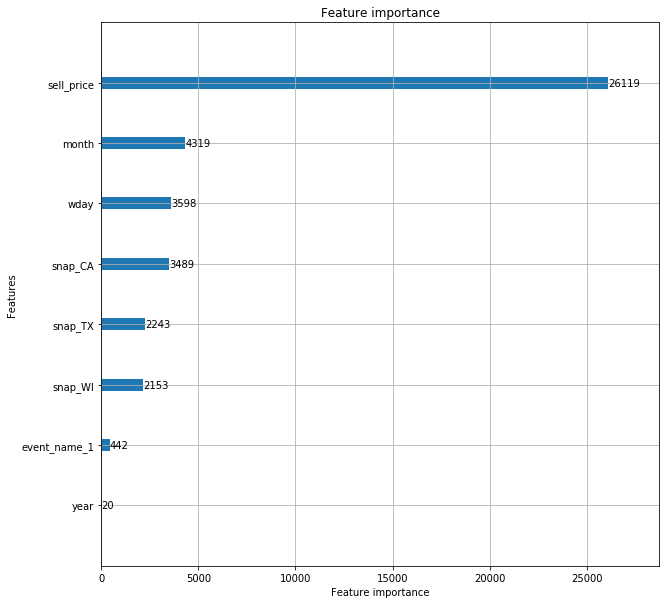

In [14]:
train_pred = gbm.predict(house_x_train, num_iteration=gbm.best_iteration)
test_pred = gbm.predict(house_x_test, num_iteration=gbm.best_iteration)

print("In train set")
print("MSE = {}  MAE = {}".format(mean_squared_error(house_y_train, train_pred), mean_absolute_error(house_y_train, train_pred)))
print("In test set")
print("MSE = {}  MAE = {}".format(mean_squared_error(house_y_test, test_pred), mean_absolute_error(house_y_test, test_pred)))
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.plot(train_pred, color='r', label='train_pred')
ax1.plot(house_y_train.values, color='b', label='train_real')
ax2.plot(test_pred, color='r', label='test_pred')
ax2.plot(house_y_test.values, color='b', label='test_real')
ax1.legend()
ax2.legend()
plt.show()
lgb.plot_importance(gbm, max_num_features=50, importance_type='split', figsize=(10,10))

# FOODS

(14370, 1919)
Num / Total  =  0.4713020662512299


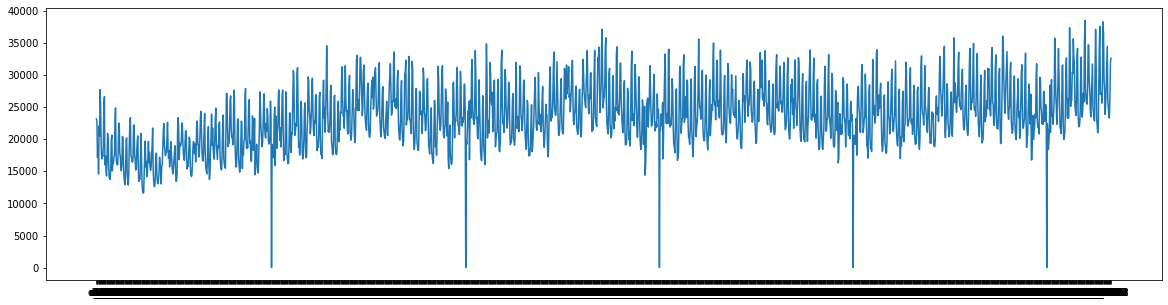

(1548, 11) (1548, 1) (365, 11) (365, 1)


/Users/jaemin/opt/anaconda3/envs/py36t2/lib/python3.6/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs
/Users/jaemin/opt/anaconda3/envs/py36t2/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
food_x_train, food_y_train, food_x_test, food_y_test = return_data_set_by_cat1(main=main, price=price, cal=cal, cat="FOODS")

In [16]:
lgb_train = lgb.Dataset(food_x_train, food_y_train)
lgb_eval = lgb.Dataset(food_x_test, food_y_test)
params = {
    'boosting_type': 'gbdt',
    'max_depth' : 10,
    'objective': 'regression',
    #'num_leaves': 10,
    'learning_rate': 0.005,
    'metric' : ['l2'],
    #multi_logloss
    #multi_error
    'random_state': 501,
    'categorical_feature':['wday', 'month', 'year', 'event_name_1','event_type_1', 'event_name_2', 'event_type_2'],
    
}

print('Starting training...')
#mdl.fit(X=train_tot,y=y_train, eval_set=(valid_tot, y_val), eval_metric=['multi_error','multi_logloss'])
gbm = lgb.train(params,lgb_train,num_boost_round=30000,valid_sets=lgb_eval,early_stopping_rounds=500)

/Users/jaemin/opt/anaconda3/envs/py36t2/lib/python3.6/site-packages/lightgbm/basic.py:842: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/Users/jaemin/opt/anaconda3/envs/py36t2/lib/python3.6/site-packages/lightgbm/basic.py:863: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Starting training...
[1]	valid_0's l2: 2.92086e+07
Training until validation scores don't improve for 500 rounds
[2]	valid_0's l2: 2.9052e+07
[3]	valid_0's l2: 2.88978e+07
[4]	valid_0's l2: 2.87443e+07
[5]	valid_0's l2: 2.8593e+07
[6]	valid_0's l2: 2.84424e+07
[7]	valid_0's l2: 2.82941e+07
[8]	valid_0's l2: 2.81465e+07
[9]	valid_0's l2: 2.8001e+07
[10]	valid_0's l2: 2.78562e+07
[11]	valid_0's l2: 2.77115e+07
[12]	valid_0's l2: 2.75695e+07
[13]	valid_0's l2: 2.74275e+07
[14]	valid_0's l2: 2.72883e+07
[15]	valid_0's l2: 2.71512e+07
[16]	valid_0's l2: 2.70147e+07
[17]	valid_0's l2: 2.68782e+07
[18]	valid_0's l2: 2.67446e+07
[19]	valid_0's l2: 2.66108e+07
[20]	valid_0's l2: 2.64798e+07
[21]	valid_0's l2: 2.63494e+07
[22]	valid_0's l2: 2.62209e+07
[23]	valid_0's l2: 2.60908e+07
[24]	valid_0's l2: 2.59649e+07
[25]	valid_0's l2: 2.58392e+07
[26]	valid_0's l2: 2.57146e+07
[27]	valid_0's l2: 2.55906e+07
[28]	valid_0's l2: 2.54683e+07
[29]	valid_0's l2: 2.53486e+07
[30]	valid_0's l2: 2.52375e+07

[411]	valid_0's l2: 1.21004e+07
[412]	valid_0's l2: 1.20939e+07
[413]	valid_0's l2: 1.20895e+07
[414]	valid_0's l2: 1.20847e+07
[415]	valid_0's l2: 1.20808e+07
[416]	valid_0's l2: 1.2074e+07
[417]	valid_0's l2: 1.20717e+07
[418]	valid_0's l2: 1.20693e+07
[419]	valid_0's l2: 1.20644e+07
[420]	valid_0's l2: 1.20586e+07
[421]	valid_0's l2: 1.20564e+07
[422]	valid_0's l2: 1.20496e+07
[423]	valid_0's l2: 1.20473e+07
[424]	valid_0's l2: 1.20448e+07
[425]	valid_0's l2: 1.20411e+07
[426]	valid_0's l2: 1.20355e+07
[427]	valid_0's l2: 1.20289e+07
[428]	valid_0's l2: 1.20263e+07
[429]	valid_0's l2: 1.2024e+07
[430]	valid_0's l2: 1.20222e+07
[431]	valid_0's l2: 1.20187e+07
[432]	valid_0's l2: 1.20143e+07
[433]	valid_0's l2: 1.20066e+07
[434]	valid_0's l2: 1.20041e+07
[435]	valid_0's l2: 1.2001e+07
[436]	valid_0's l2: 1.19934e+07
[437]	valid_0's l2: 1.19911e+07
[438]	valid_0's l2: 1.19852e+07
[439]	valid_0's l2: 1.1981e+07
[440]	valid_0's l2: 1.1978e+07
[441]	valid_0's l2: 1.19765e+07
[442]	valid_0

[811]	valid_0's l2: 1.13553e+07
[812]	valid_0's l2: 1.13537e+07
[813]	valid_0's l2: 1.13542e+07
[814]	valid_0's l2: 1.13522e+07
[815]	valid_0's l2: 1.13499e+07
[816]	valid_0's l2: 1.1347e+07
[817]	valid_0's l2: 1.13474e+07
[818]	valid_0's l2: 1.13455e+07
[819]	valid_0's l2: 1.1344e+07
[820]	valid_0's l2: 1.13445e+07
[821]	valid_0's l2: 1.13428e+07
[822]	valid_0's l2: 1.13413e+07
[823]	valid_0's l2: 1.13384e+07
[824]	valid_0's l2: 1.13389e+07
[825]	valid_0's l2: 1.13366e+07
[826]	valid_0's l2: 1.13351e+07
[827]	valid_0's l2: 1.13333e+07
[828]	valid_0's l2: 1.13314e+07
[829]	valid_0's l2: 1.13314e+07
[830]	valid_0's l2: 1.13286e+07
[831]	valid_0's l2: 1.13273e+07
[832]	valid_0's l2: 1.13293e+07
[833]	valid_0's l2: 1.13297e+07
[834]	valid_0's l2: 1.13288e+07
[835]	valid_0's l2: 1.13292e+07
[836]	valid_0's l2: 1.13297e+07
[837]	valid_0's l2: 1.13294e+07
[838]	valid_0's l2: 1.13298e+07
[839]	valid_0's l2: 1.13289e+07
[840]	valid_0's l2: 1.13293e+07
[841]	valid_0's l2: 1.13302e+07
[842]	vali

[1235]	valid_0's l2: 1.09184e+07
[1236]	valid_0's l2: 1.09166e+07
[1237]	valid_0's l2: 1.09158e+07
[1238]	valid_0's l2: 1.09157e+07
[1239]	valid_0's l2: 1.09144e+07
[1240]	valid_0's l2: 1.09134e+07
[1241]	valid_0's l2: 1.09133e+07
[1242]	valid_0's l2: 1.09115e+07
[1243]	valid_0's l2: 1.09111e+07
[1244]	valid_0's l2: 1.09102e+07
[1245]	valid_0's l2: 1.09121e+07
[1246]	valid_0's l2: 1.09115e+07
[1247]	valid_0's l2: 1.09134e+07
[1248]	valid_0's l2: 1.09142e+07
[1249]	valid_0's l2: 1.09145e+07
[1250]	valid_0's l2: 1.0916e+07
[1251]	valid_0's l2: 1.09142e+07
[1252]	valid_0's l2: 1.09139e+07
[1253]	valid_0's l2: 1.09128e+07
[1254]	valid_0's l2: 1.09135e+07
[1255]	valid_0's l2: 1.09145e+07
[1256]	valid_0's l2: 1.09152e+07
[1257]	valid_0's l2: 1.09148e+07
[1258]	valid_0's l2: 1.09151e+07
[1259]	valid_0's l2: 1.09149e+07
[1260]	valid_0's l2: 1.09131e+07
[1261]	valid_0's l2: 1.09137e+07
[1262]	valid_0's l2: 1.09119e+07
[1263]	valid_0's l2: 1.09122e+07
[1264]	valid_0's l2: 1.09129e+07
[1265]	vali

[1664]	valid_0's l2: 1.07568e+07
[1665]	valid_0's l2: 1.07567e+07
[1666]	valid_0's l2: 1.0755e+07
[1667]	valid_0's l2: 1.0755e+07
[1668]	valid_0's l2: 1.07551e+07
[1669]	valid_0's l2: 1.07545e+07
[1670]	valid_0's l2: 1.07544e+07
[1671]	valid_0's l2: 1.07542e+07
[1672]	valid_0's l2: 1.07598e+07
[1673]	valid_0's l2: 1.07606e+07
[1674]	valid_0's l2: 1.07601e+07
[1675]	valid_0's l2: 1.07583e+07
[1676]	valid_0's l2: 1.07578e+07
[1677]	valid_0's l2: 1.07583e+07
[1678]	valid_0's l2: 1.07574e+07
[1679]	valid_0's l2: 1.07594e+07
[1680]	valid_0's l2: 1.07593e+07
[1681]	valid_0's l2: 1.07649e+07
[1682]	valid_0's l2: 1.07656e+07
[1683]	valid_0's l2: 1.0765e+07
[1684]	valid_0's l2: 1.07633e+07
[1685]	valid_0's l2: 1.07614e+07
[1686]	valid_0's l2: 1.07598e+07
[1687]	valid_0's l2: 1.0759e+07
[1688]	valid_0's l2: 1.07586e+07
[1689]	valid_0's l2: 1.07582e+07
[1690]	valid_0's l2: 1.07563e+07
[1691]	valid_0's l2: 1.07562e+07
[1692]	valid_0's l2: 1.0756e+07
[1693]	valid_0's l2: 1.07546e+07
[1694]	valid_0'

[2073]	valid_0's l2: 1.07305e+07
[2074]	valid_0's l2: 1.07278e+07
[2075]	valid_0's l2: 1.07281e+07
[2076]	valid_0's l2: 1.0727e+07
[2077]	valid_0's l2: 1.07265e+07
[2078]	valid_0's l2: 1.07256e+07
[2079]	valid_0's l2: 1.0725e+07
[2080]	valid_0's l2: 1.07259e+07
[2081]	valid_0's l2: 1.07255e+07
[2082]	valid_0's l2: 1.07245e+07
[2083]	valid_0's l2: 1.07259e+07
[2084]	valid_0's l2: 1.07251e+07
[2085]	valid_0's l2: 1.07242e+07
[2086]	valid_0's l2: 1.07249e+07
[2087]	valid_0's l2: 1.07223e+07
[2088]	valid_0's l2: 1.07219e+07
[2089]	valid_0's l2: 1.07196e+07
[2090]	valid_0's l2: 1.07188e+07
[2091]	valid_0's l2: 1.07224e+07
[2092]	valid_0's l2: 1.07206e+07
[2093]	valid_0's l2: 1.07194e+07
[2094]	valid_0's l2: 1.07186e+07
[2095]	valid_0's l2: 1.0718e+07
[2096]	valid_0's l2: 1.07162e+07
[2097]	valid_0's l2: 1.07161e+07
[2098]	valid_0's l2: 1.07135e+07
[2099]	valid_0's l2: 1.07131e+07
[2100]	valid_0's l2: 1.07112e+07
[2101]	valid_0's l2: 1.07106e+07
[2102]	valid_0's l2: 1.07096e+07
[2103]	valid_

[2437]	valid_0's l2: 1.06858e+07
[2438]	valid_0's l2: 1.06855e+07
[2439]	valid_0's l2: 1.06841e+07
[2440]	valid_0's l2: 1.06842e+07
[2441]	valid_0's l2: 1.06838e+07
[2442]	valid_0's l2: 1.06835e+07
[2443]	valid_0's l2: 1.06851e+07
[2444]	valid_0's l2: 1.06868e+07
[2445]	valid_0's l2: 1.06863e+07
[2446]	valid_0's l2: 1.06849e+07
[2447]	valid_0's l2: 1.0686e+07
[2448]	valid_0's l2: 1.06869e+07
[2449]	valid_0's l2: 1.0687e+07
[2450]	valid_0's l2: 1.06918e+07
[2451]	valid_0's l2: 1.06912e+07
[2452]	valid_0's l2: 1.06909e+07
[2453]	valid_0's l2: 1.06895e+07
[2454]	valid_0's l2: 1.06906e+07
[2455]	valid_0's l2: 1.06918e+07
[2456]	valid_0's l2: 1.06921e+07
[2457]	valid_0's l2: 1.0693e+07
[2458]	valid_0's l2: 1.06927e+07
[2459]	valid_0's l2: 1.06936e+07
[2460]	valid_0's l2: 1.06937e+07
[2461]	valid_0's l2: 1.06945e+07
[2462]	valid_0's l2: 1.06992e+07
[2463]	valid_0's l2: 1.06988e+07
[2464]	valid_0's l2: 1.06998e+07
[2465]	valid_0's l2: 1.07001e+07
[2466]	valid_0's l2: 1.06986e+07
[2467]	valid_

[2841]	valid_0's l2: 1.08841e+07
[2842]	valid_0's l2: 1.08851e+07
[2843]	valid_0's l2: 1.08847e+07
[2844]	valid_0's l2: 1.0888e+07
[2845]	valid_0's l2: 1.08876e+07
[2846]	valid_0's l2: 1.0887e+07
[2847]	valid_0's l2: 1.08869e+07
[2848]	valid_0's l2: 1.0887e+07
[2849]	valid_0's l2: 1.08868e+07
[2850]	valid_0's l2: 1.08865e+07
[2851]	valid_0's l2: 1.08859e+07
[2852]	valid_0's l2: 1.08896e+07
[2853]	valid_0's l2: 1.08889e+07
[2854]	valid_0's l2: 1.08882e+07
[2855]	valid_0's l2: 1.0888e+07
[2856]	valid_0's l2: 1.08918e+07
[2857]	valid_0's l2: 1.08911e+07
[2858]	valid_0's l2: 1.08907e+07
[2859]	valid_0's l2: 1.08885e+07
[2860]	valid_0's l2: 1.08922e+07
Early stopping, best iteration is:
[2360]	valid_0's l2: 1.0668e+07


In train set
MSE = 1717422.664943801  MAE = 807.8518703539892
In test set
MSE = 10699666.303323235  MAE = 2470.6737317730194


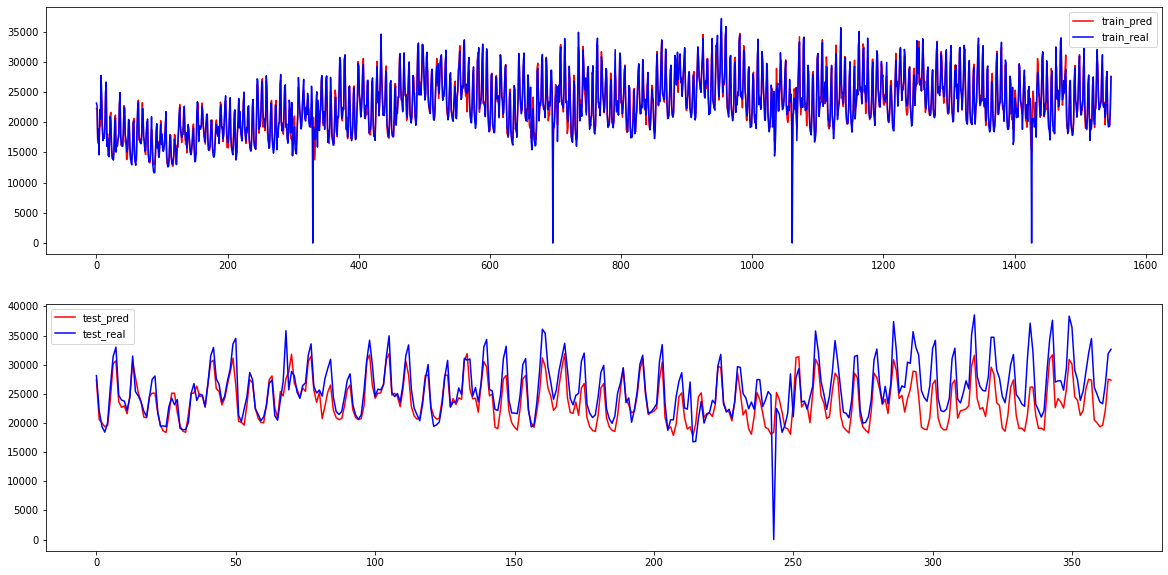

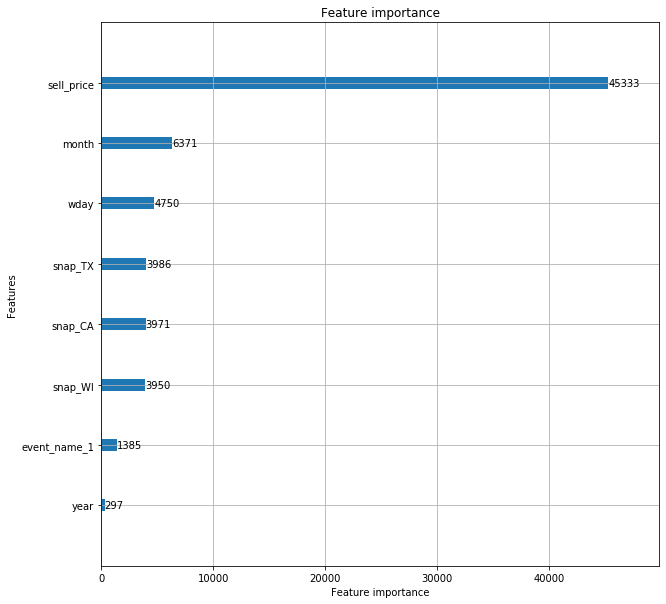

In [17]:
train_pred = gbm.predict(food_x_train, num_iteration=gbm.best_iteration)
test_pred = gbm.predict(food_x_test, num_iteration=gbm.best_iteration)

print("In train set")
print("MSE = {}  MAE = {}".format(mean_squared_error(food_y_train, train_pred), mean_absolute_error(food_y_train, train_pred)))
print("In test set")
print("MSE = {}  MAE = {}".format(mean_squared_error(food_y_test, test_pred), mean_absolute_error(food_y_test, test_pred)))
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.plot(train_pred, color='r', label='train_pred')
ax1.plot(food_y_train.values, color='b', label='train_real')
ax2.plot(test_pred, color='r', label='test_pred')
ax2.plot(food_y_test.values, color='b', label='test_real')
ax1.legend()
ax2.legend()
plt.show()
lgb.plot_importance(gbm, max_num_features=50, importance_type='split', figsize=(10,10))